# A Quick Demo of Andrej Karpathy's minGPT Play Char Demo 
- You can find the Play Char demo in the minGPT repo here: https://github.com/karpathy/minGPT
- Goal: Generate Shakespere

This notebook is partially based on the fastai Transformers tutorial: http://docs.fast.ai/tutorial.transformers

**Note**:
- This needs the minGPT repo downloaded in the same folder as this notebook

In [1]:
from fastai.text.all import *
from minGPT.mingpt.model import GPT, GPTConfig, GPT1Config

# Data

You can download the raw text file at: https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt

In [2]:
raw_text = open('input.txt', 'r').read()
raw_text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

## Data Loaders

In [3]:
class CharTransform(Transform):
    def __init__(self, data, block_size):
        chars = list(set(data))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
        self.n_sequences = math.ceil(len(self.data) / (self.block_size + 1))
    
    def encodes(self, o):
        i = np.random.randint(0, len(self.data) - (self.block_size + 1))
        chunk = self.data[i:i+self.block_size+1]
        dix = [self.stoi[s] for s in chunk]
        return torch.tensor(dix)
    
    def decodes(self, o):
        t = ''.join([self.itos[s.item()] for s in o])
        return TitledStr(t)

**Note**:
- Note `block_size` in Karpathy's code is equivalent to `Sequence Length` in fastai
- We do not specify a validation set here as Karpathy does not in their notebook. Therefore we set `split_idx=0` in `TfmdLists`

In [4]:
sl = 128
block_size = sl
n_samples = math.ceil(len(raw_text) / (block_size + 1))

tls = TfmdLists(list(range(n_samples)), tfms=[CharTransform(raw_text, 128)], split_idx=0, dl_type=LMDataLoader)

data has 1115394 characters, 65 unique.


We specify `dl_type=LMDataLoader` for when we will convert this `TfmdLists` to `DataLoaders`: we will use an `LMDataLoader` since we have a language modeling problem, not the usual fastai `TfmdDL`.

In [5]:
show_at(tls.train, 0)

e them?

LADY GREY:
What you command, that rests in me to do.

KING EDWARD IV:
But you will take exceptions to my boon.

LADY GRE


The fastai library expects the data to be assembled in a `DataLoaders` object (something that has a training and validation dataloader). We can get one by using the `dataloaders` method. We just have to specify a batch size and a sequence length. 

In [6]:
bs = 256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [16]:
#o = dls.one_batch(); len(o), o[0].size(), o[1].size(), o

In [8]:
dls.show_batch(max_n=2)

,text,text_
0,"que time would lie unswept,\nAnd mountainous error be too highly heapt\nFor truth to o'er-peer. Rather than fool it so,\nLet the hi","ue time would lie unswept,\nAnd mountainous error be too highly heapt\nFor truth to o'er-peer. Rather than fool it so,\nLet the hig"
1,"an action and capacity,\nOf notill stand there,\nRemembering how I love thy company.\n\nROMEO:\nAnd I'll still stay, to have thee sti","n action and capacity,\nOf notill stand there,\nRemembering how I love thy company.\n\nROMEO:\nAnd I'll still stay, to have thee stil"


## Callback to Grab First Output

Here we need to write the event `after_pred` and replace `self.learn.pred` (which contains the predictions that will be passed to the loss function) by just its first element. This is because Karpathy's model actually also calculates the loss in the forward pass, and returns (logits, loss). We only need the logits.

In callbacks, there is a shortcut that lets you access any of the underlying `Learner` attribute so we can write `self.pred[0]` instead of `self.learn.pred[0]`. That shorcut only works for read access, not write, so we have to write `self.learn.pred` on the right side (otherwise we would set a `pred` attribute in the `Callback`).

In [9]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

## GPT Model

I had to use 6 layers instead of 8 as my 2080 GPU has 13GB of ram

In [10]:
mconf = GPTConfig(dls.char_transform.vocab_size, sl, n_layer=6, n_head=8, n_embd=512)
model = GPT(mconf)

## Learner

In [18]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), opt_func=partial(Adam, sqr_mom=0.95, wd=0.1), 
                cbs=[DropOutput]).to_fp16()

In [19]:
learn.lr_find()

RuntimeError: value cannot be converted to type at::Half without overflow: -1e+10

In [11]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), opt_func=partial(Adam, sqr_mom=0.95, wd=0.1), 
                cbs=[DropOutput]) #.to_fp16()

/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=2.511886486900039e-05)

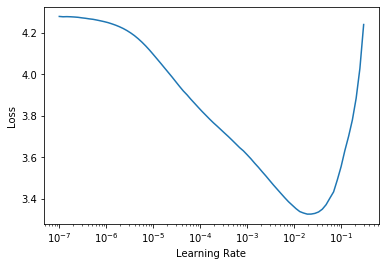

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(100, 6e-4, div_final=10)    

# div_final=10 will ensure we finish at the same lr as Karpathy

epoch,train_loss,valid_loss,time
0,3.338925,None,00:18
1,3.062790,None,00:18
2,2.832788,None,00:19
3,2.687037,None,00:19
4,2.595154,None,00:19
5,2.532446,None,00:19
6,2.486231,None,00:19
7,2.451136,None,00:19
8,2.417365,None,00:19
9,2.380837,None,00:19


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


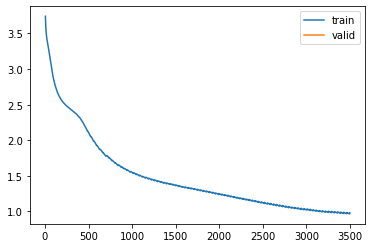

In [14]:
learn.recorder.plot_loss()

Note there is no validation loss or validation perplexity as we we didn't specify a validation set (as per Karpathy's notebook)

In [15]:
from minGPT.mingpt.utils import sample

context = "O God, O God!"
x = torch.tensor([dls.char_transform.stoi[s] for s in context], dtype=torch.long)[None,...].to(dls.device)
y = sample(model, x, 2000, temperature=0.9, sample=True, top_k=5)[0]
completion = ''.join([dls.char_transform.itos[int(i)] for i in y])
print(completion)

O God, O God! to our bloody supply the horsemen are stay and forth. But wherefore stand you to the crown?

DUKE VINCENTIO:
These are the people's voices,
To make the varlet concerning me to town.
I was no brother out the man that wilt thou have made forth thyself.

GLOUCESTER:
This is a man, and thy supposed king,
Like men cracking in the world,
Which were instruction mortal tiden let us hence;
And, for the dangerous seats of the earth
Would be the sheep that was thus fined
An an unusual good deeds, that does not.

CORIOLANUS:
Why that is this?

FRANCISCA:
What was? much of you, if I show much, we have said
Shall be your first with your shame, take you into
the court: back up my packet again of his silk,
And that you might repossess him well
Then when he did show more wantons,
Than the proudest hollow can find it off.

MARCIUS:
Though they shall feel, they change put us on you.

CLARENCE:
Or the duke's death, the love been done:
I am so broad to live in thee and thy looks.

RICHARD:
I 